# Persiapan dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import requests
from io import StringIO
import seaborn as sns

# Memuat dataset dari URL dengan delimiter tab (\t)
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/clusteringcampaign.csv'
response = requests.get(url)
data = pd.read_csv(StringIO(response.text), sep='\t')

# Tampilkan informasi dataset
print("Dataset Information:")
print(data.info())
print("\nDataset Head:")
print(data.head())
print("\nDataset Description:")
print(data.describe())

# Cek missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Preprocessing data
# Pilih kolom numerik untuk clustering (exclude ID jika ada)
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns: {numeric_columns}")

# Ambil data numerik dan hapus missing values jika ada
X = data[numeric_columns].dropna()
print(f"\nData shape after preprocessing: {X.shape}")

# Standardisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases

#  FUNGSI UNTUK MENGHITUNG METRIK EVALUASI



In [6]:
def dunn_index(X, labels):
    """
    Menghitung Dunn Index
    Dunn Index = min(inter-cluster distance) / max(intra-cluster distance)
    Semakin tinggi nilai Dunn Index, semakin baik clustering
    """
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters < 2:
        return 0

    # Hitung intra-cluster distances (jarak dalam cluster)
    intra_cluster_distances = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            distances = pdist(cluster_points)
            intra_cluster_distances.extend(distances)

    max_intra_distance = max(intra_cluster_distances) if intra_cluster_distances else 0

    # Hitung inter-cluster distances (jarak antar cluster)
    inter_cluster_distances = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            distances = cdist(cluster_i, cluster_j)
            inter_cluster_distances.append(np.min(distances))

    min_inter_distance = min(inter_cluster_distances) if inter_cluster_distances else 0

    if max_intra_distance == 0:
        return float('inf')

    return min_inter_distance / max_intra_distance

def evaluate_clustering(X, labels, model_name):
    """
    Evaluasi clustering dengan berbagai metrik
    """
    n_clusters = len(np.unique(labels))

    # Silhouette Score: [-1, 1], semakin tinggi semakin baik
    silhouette = silhouette_score(X, labels)

    # Calinski-Harabasz Index: semakin tinggi semakin baik
    calinski_harabasz = calinski_harabasz_score(X, labels)

    # Davies-Bouldin Index: semakin rendah semakin baik
    davies_bouldin = davies_bouldin_score(X, labels)

    # Dunn Index: semakin tinggi semakin baik
    dunn = dunn_index(X, labels)

    results = {
        'Model': model_name,
        'N_Clusters': n_clusters,
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Davies-Bouldin Index': davies_bouldin,
        'Dunn Index': dunn
    }

    return results

# ELBOW METHOD UNTUK MENENTUKAN JUMLAH CLUSTER OPTIMAL

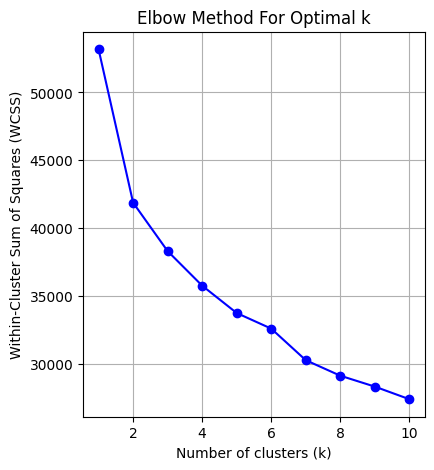

In [7]:
def elbow_method(X, max_clusters=10):
    """
    Implementasi Elbow Method
    Within-Cluster Sum of Squares (WCSS) = Σ(distance dari setiap point ke centroid cluster)
    """
    wcss = []
    K_range = range(1, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    return K_range, wcss

# Hitung Elbow Method untuk KMeans
K_range, wcss = elbow_method(X_scaled, max_clusters=10)

# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(K_range, wcss, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)

# SILHOUETTE ANALYSIS & CALINSKI-HARABASZ INDEX

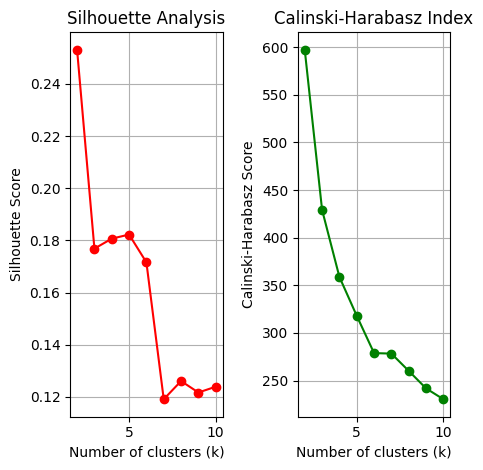


Jumlah cluster optimal yang dipilih: 3


In [8]:
def silhouette_analysis(X, max_clusters=10):
    """
    Analisis Silhouette Score untuk berbagai jumlah cluster
    """
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    return K_range, silhouette_scores

# Hitung Silhouette Scores
K_range_sil, silhouette_scores = silhouette_analysis(X_scaled, max_clusters=10)

# Plot Silhouette Analysis
plt.subplot(1, 3, 2)
plt.plot(K_range_sil, silhouette_scores, 'ro-')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# =============================================================================
#  CALINSKI-HARABASZ INDEX
# =============================================================================

def calinski_harabasz_analysis(X, max_clusters=10):
    """
    Analisis Calinski-Harabasz Index
    """
    ch_scores = []
    K_range = range(2, max_clusters + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = calinski_harabasz_score(X, labels)
        ch_scores.append(score)

    return K_range, ch_scores

# Hitung Calinski-Harabasz Scores
K_range_ch, ch_scores = calinski_harabasz_analysis(X_scaled, max_clusters=10)

# Plot Calinski-Harabasz Analysis
plt.subplot(1, 3, 3)
plt.plot(K_range_ch, ch_scores, 'go-')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# =============================================================================
# MENENTUKAN JUMLAH CLUSTER OPTIMAL
# =============================================================================

# Berdasarkan analisis di atas, pilih k optimal (misalnya k=3)
optimal_k = 3
print(f"\nJumlah cluster optimal yang dipilih: {optimal_k}")


# IMPLEMENTASI DUA MODEL CLUSTERING

In [9]:
# Model 1: K-Means Clustering
print("\n" + "="*50)
print("MODEL 1: K-MEANS CLUSTERING")
print("="*50)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluasi K-Means
kmeans_results = evaluate_clustering(X_scaled, kmeans_labels, "K-Means")
print(f"K-Means Results:")
for key, value in kmeans_results.items():
    print(f"  {key}: {value}")

# Model 2: Agglomerative Clustering (Hierarchical)
print("\n" + "="*50)
print("MODEL 2: AGGLOMERATIVE CLUSTERING")
print("="*50)

agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

# Evaluasi Agglomerative Clustering
agg_results = evaluate_clustering(X_scaled, agg_labels, "Agglomerative")
print(f"Agglomerative Clustering Results:")
for key, value in agg_results.items():
    print(f"  {key}: {value}")


MODEL 1: K-MEANS CLUSTERING
K-Means Results:
  Model: K-Means
  N_Clusters: 3
  Silhouette Score: 0.17684532918016807
  Calinski-Harabasz Index: 429.23691933578
  Davies-Bouldin Index: 2.18245141656376
  Dunn Index: 0.026280182853446375

MODEL 2: AGGLOMERATIVE CLUSTERING
Agglomerative Clustering Results:
  Model: Agglomerative
  N_Clusters: 3
  Silhouette Score: 0.19473470003716356
  Calinski-Harabasz Index: 358.89033871871146
  Davies-Bouldin Index: 2.290382403372826
  Dunn Index: 0.05163694714039745


# PERBANDINGAN METRIK EVALUASI

In [10]:
print("\n" + "="*50)
print("PERBANDINGAN METRIK EVALUASI")
print("="*50)

# Buat DataFrame untuk perbandingan
comparison_df = pd.DataFrame([kmeans_results, agg_results])
print(comparison_df.to_string(index=False))


PERBANDINGAN METRIK EVALUASI
        Model  N_Clusters  Silhouette Score  Calinski-Harabasz Index  Davies-Bouldin Index  Dunn Index
      K-Means           3          0.176845               429.236919              2.182451    0.026280
Agglomerative           3          0.194735               358.890339              2.290382    0.051637


# VISUALISASI HASIL CLUSTERING


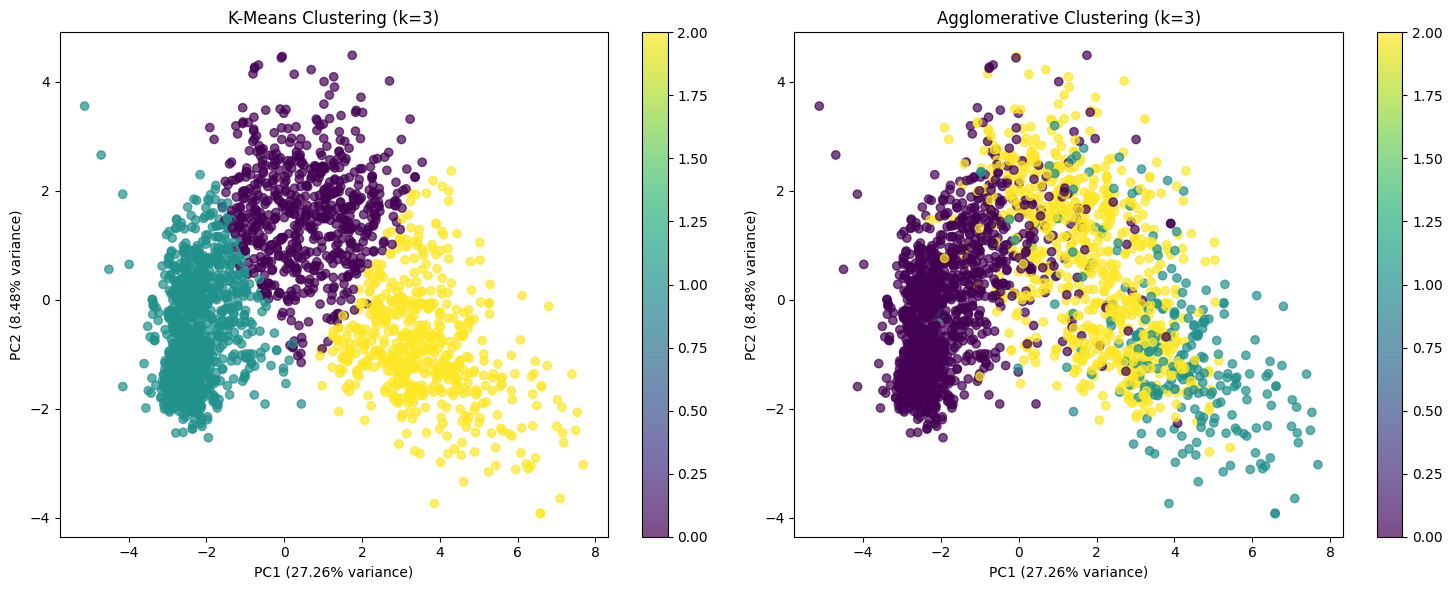

In [11]:
# Reduksi dimensi dengan PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot hasil clustering
plt.figure(figsize=(15, 6))

# K-Means visualization
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

# Agglomerative Clustering visualization
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', alpha=0.7)
plt.title(f'Agglomerative Clustering (k={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

======================================================================
ANALISIS DETAIL METRIK EVALUASI
======================================================================

Silhouette Score:
 - Range: [-1, 1]
 - Better when: Higher
 - Formula: s(i) = (b(i) - a(i)) / max(a(i), b(i))
 - Description: Mengukur seberapa mirip objek dengan cluster sendiri vs cluster lain

Calinski-Harabasz Index:
 - Range: [0, ∞)
 - Better when: Higher
 - Formula: CH = (SSB/(k-1)) / (SSW/(n-k))
 - Description: Rasio antara dispersi antar-cluster dan dalam-cluster

Davies-Bouldin Index:
- Range: [0, ∞)
- Better when: Lower
- Formula: DB = (1/k) * Σ max((σᵢ + σⱼ)/d(cᵢ,cⱼ))
- Description: Rata-rata similarity maksimum antara setiap cluster dengan cluster terdekat

Dunn Index:
  - Range: [0, ∞)
  - Better when: Higher
  - Formula: DI = min(inter-cluster distance) / max(intra-cluster distance)
  - Description: Rasio jarak minimum antar-cluster dengan jarak maksimum dalam-cluster

RANKING METRIK EVALUASI CLUSTERING (dari terbaik):

1. SILHOUETTE SCORE
   - Paling umum dan mudah diinterpretasi
   - Mempertimbangkan cohesion (kedekatan dalam cluster) dan separation (pemisahan antar cluster)
   - Range [-1,1] mudah dipahami
   - Robust terhadap bentuk cluster yang berbeda

2. CALINSKI-HARABASZ INDEX
   - Baik untuk dataset dengan cluster yang kompak dan terpisah jelas
   - Cepat dihitung
   - Tidak memiliki batas atas, sehingga perbandingan relatif

3. DAVIES-BOULDIN INDEX
   - Mudah diinterpretasi (semakin rendah semakin baik)
   - Mempertimbangkan kompaksi cluster dan pemisahan antar cluster
   - Sensitif terhadap outlier

4. DUNN INDEX
   - Konsep yang intuitif dan mudah dipahami
   - Sangat sensitif terhadap outlier
   - Komputasi lebih lambat untuk dataset besar
   - Cenderung memberikan nilai rendah bahkan untuk clustering yang baik

KESIMPULAN:
Gunakan kombinasi SILHOUETTE SCORE dan CALINSKI-HARABASZ INDEX untuk evaluasi
yang paling reliable. Silhouette Score untuk interpretabilitas, dan
Calinski-Harabasz untuk konfirmasi pada dataset dengan cluster kompak.

In [13]:
print("\n" + "="*50)
print("KARAKTERISTIK CLUSTER")
print("="*50)

# Tambahkan label cluster ke dataset original
data_with_clusters = X.copy()
data_with_clusters['KMeans_Cluster'] = kmeans_labels
data_with_clusters['Agglomerative_Cluster'] = agg_labels

# Statistik deskriptif per cluster untuk K-Means
print("\nK-Means - Statistik per Cluster:")
kmeans_stats = data_with_clusters.groupby('KMeans_Cluster')[numeric_columns].mean()
print(kmeans_stats)

print("\nAgglomerative - Statistik per Cluster:")
agg_stats = data_with_clusters.groupby('Agglomerative_Cluster')[numeric_columns].mean()
print(agg_stats)

# Ukuran cluster
print(f"\nUkuran Cluster K-Means:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

print(f"\nUkuran Cluster Agglomerative:")
print(pd.Series(agg_labels).value_counts().sort_index())


KARAKTERISTIK CLUSTER

K-Means - Statistik per Cluster:
                         ID   Year_Birth        Income   Kidhome  Teenhome  \
KMeans_Cluster                                                               
0               5408.271451  1964.375975  58354.039002  0.195008  0.909516   
1               5632.675728  1971.675728  34889.717476  0.806796  0.445631   
2               5716.390826  1968.651376  77868.919266  0.042202  0.143119   

                  Recency    MntWines  MntFruits  MntMeatProducts  \
KMeans_Cluster                                                      
0               48.009360  461.998440  24.812793       140.435257   
1               49.395146   42.758252   4.968932        23.622330   
2               49.469725  616.332110  68.590826       469.198165   

                MntFishProducts  ...  NumWebVisitsMonth  AcceptedCmp3  \
KMeans_Cluster                   ...                                    
0                     33.257410  ...           5.614665     